# Lab Assignment 2 - Part C: Naive Bayes for Spam Detection
Please refer to the `README.pdf` for full laboratory instructions.


## Problem Statement
In this part, you will implement a **Naive Bayes classifier** for spam email detection using the Spambase dataset.

### Dataset Description
The Spambase dataset contains 4601 email samples with 57 features:
- **Features 1-48**: Word frequencies (percentage of words matching specific words)
- **Features 49-54**: Character frequencies (`;`, `(`, `[`, `!`, `$`, `#`)
- **Features 55-57**: Capital letter statistics
- **Label**: 1 = spam, 0 = not spam

### Your Tasks
1. **Implement Gaussian Naive Bayes** from scratch
2. **Train and evaluate** your classifier (accuracy, precision, recall, F1-score)
3. **Feature analysis**: Identify top discriminative features
4. **Discussion**: Why does Naive Bayes work for spam detection?


## Setup


In [65]:
%pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [66]:
# Library declarations
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


## Load the Spambase Dataset


In [67]:
# Fetch Spambase dataset from UCI ML Repository
spambase = fetch_ucirepo(id=94)

# Get features and labels
X = spambase.data.features.values
y = spambase.data.targets.values.ravel()
feature_names = list(spambase.data.features.columns)

print(f"Dataset shape: {X.shape}")
print(f"Number of spam emails: {np.sum(y == 1)}")
print(f"Number of non-spam emails: {np.sum(y == 0)}")
print(f"\nFeature names: {list(spambase.data.features.columns[:10])}...")  # First 10 features


Dataset shape: (4601, 57)
Number of spam emails: 1813
Number of non-spam emails: 2788

Feature names: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail']...


In [68]:
# Split data into training (80%) and testing (20%) sets
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    np.random.seed(random_state)
    n_samples = len(y)
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 3681 samples
Testing set: 920 samples


## Task 1: Implement Gaussian Naive Bayes
Implement a Gaussian Naive Bayes classifier from scratch.

**Key formulas:**
- Class prior: $P(C) = \frac{N_C}{N}$
- Gaussian likelihood: $P(x_i|C) = \frac{1}{\sqrt{2\pi\sigma_{i,C}^2}} \exp\left(-\frac{(x_i - \mu_{i,C})^2}{2\sigma_{i,C}^2}\right)$
- Use **log-probabilities** to avoid numerical underflow!


In [69]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None      # P(C) for each class
        self.means = None       # Mean of each feature per class
        self.variances = None   # Variance of each feature per class
    
    def fit(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        y : numpy array of shape (n_samples,)
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).reshape(-1)

        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.priors = np.zeros((n_classes,), dtype=float)
        self.means = np.zeros((n_classes, n_features), dtype=float)
        self.variances = np.zeros((n_classes, n_features), dtype=float)

        for idx, c in enumerate(self.classes):
            Xc = X[y == c]
            self.priors[idx] = Xc.shape[0] / X.shape[0]
            self.means[idx] = np.mean(Xc, axis=0)
            self.variances[idx] = np.var(Xc, axis=0)
    
        return self
    
    def _gaussian_log_likelihood(self, x, mean, var):
        """
        Calculate log of Gaussian probability density.
        
        Returns:
        --------
        log_likelihood : float
        """
        # TODO: Implement log of Gaussian PDF
        # log P(x|C) = -0.5 * log(2*pi*var) - 0.5 * (x - mean)^2 / var
        return -0.5 * np.log(2.0 * np.pi * var) - 0.5 * ((x - mean) ** 2) / var
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        
        Returns:
        --------
        predictions : numpy array of shape (n_samples,)
        """
        X = np.asarray(X, dtype=float)
        log_priors = np.log(self.priors)

        preds = np.zeros((X.shape[0],), dtype=self.classes.dtype)
        for i, x in enumerate(X):
            log_posts = []
            for ci in range(len(self.classes)):
                ll = self._gaussian_log_likelihood(x, self.means[ci], self.variances[ci]).sum()
                log_posts.append(log_priors[ci] + ll)
            preds[i] = self.classes[int(np.argmax(log_posts))]
        return preds
    
    def predict_proba(self, X):
        """
        Return probability estimates for samples.
        
        Returns:
        --------
        probabilities : numpy array of shape (n_samples, n_classes)
        """
        X = np.asarray(X, dtype=float)
        log_priors = np.log(self.priors)
        log_posts = np.zeros((X.shape[0], len(self.classes)), dtype=float)

        for i, x in enumerate(X):
            for ci in range(len(self.classes)):
                ll = self._gaussian_log_likelihood(x, self.means[ci], self.variances[ci]).sum()
                log_posts[i, ci] = log_priors[ci] + ll

        # convert log-posteriors to probabilities via softmax
        m = np.max(log_posts, axis=1, keepdims=True)
        probs = np.exp(log_posts - m)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        return probs


## Task 2: Train and Evaluate
Train your classifier and compute evaluation metrics.


In [70]:
import numpy as np

def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, precision, recall, F1, and a 2x2 confusion matrix.

    Confusion matrix format:
        [[TN, FP],
         [FN, TP]]
    where "positive" corresponds to spam=1.
    """
    positive_label=1
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_pred = np.asarray(y_pred).astype(int).reshape(-1)

    TP = int(np.sum((y_true == positive_label) & (y_pred == positive_label)))
    TN = int(np.sum((y_true != positive_label) & (y_pred != positive_label)))
    FP = int(np.sum((y_true != positive_label) & (y_pred == positive_label)))
    FN = int(np.sum((y_true == positive_label) & (y_pred != positive_label)))

    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Guard against division by zero
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    confusion = np.array([[TN, FP],
                          [FN, TP]], dtype=int)

    return float(accuracy)*100, float(precision)*100, float(recall)*100, float(f1)*100, confusion


"""
def confusion_matrix(y_true, y_pred):
   
    Create confusion matrix.
    
    Returns:
    --------
    matrix : numpy array of shape (2, 2)
        [[TN, FP], [FN, TP]]
   
    # TODO: Implement confusion matrix
    pass
"""

'\ndef confusion_matrix(y_true, y_pred):\n   \n    Create confusion matrix.\n    \n    Returns:\n    --------\n    matrix : numpy array of shape (2, 2)\n        [[TN, FP], [FN, TP]]\n   \n    # TODO: Implement confusion matrix\n    pass\n'

## Task 3: Feature Analysis
Identify the most discriminative features for spam detection.


In [71]:
# TODO: Train your classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)

# TODO: Make predictions
y_pred = nb_classifier.predict(X_test)

# Compute and print metrics
accuracy, precision, recall, f1, confusion = compute_metrics(y_test, y_pred)

print("Gaussian Naive Bayes Results")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}\n")

# TODO: Create and display confusion matrix
print("Confusion Matrix:\n", confusion)

Gaussian Naive Bayes Results
Accuracy : 82.1739
Precision: 72.3320
Recall   : 93.8462
F1-score : 81.6964

Confusion Matrix:
 [[390 140]
 [ 24 366]]


In [ ]:
# TODO: Identify top 5 most discriminative features
classes = nb_classifier.classes
idx_spam = int(np.where(classes == 1)[0][0])
idx_benign = int(np.where(classes == 0)[0][0])

mu_spam = nb_classifier.means[idx_spam]
mu_benign = nb_classifier.means[idx_benign]
var_spam = nb_classifier.variances[idx_spam]
var_benign = nb_classifier.variances[idx_benign]

scores = np.abs(mu_spam - mu_benign) / np.sqrt(var_spam + var_benign + 1e-12)
top_5_indices = np.argsort(scores)[::-1][:5]

print("Top 5 discriminative features:")
for idx in top_5_indices:
    name = feature_names[idx]
    print(f"  {idx:>2d} ({name}): {scores[idx]:.6f}")



Top 5 discriminative features:
  20 (word_freq_your): 0.587394
   6 (word_freq_remove): 0.470694
  22 (word_freq_000): 0.462742
  52 (char_freq_$): 0.441569
  18 (word_freq_you): 0.424428


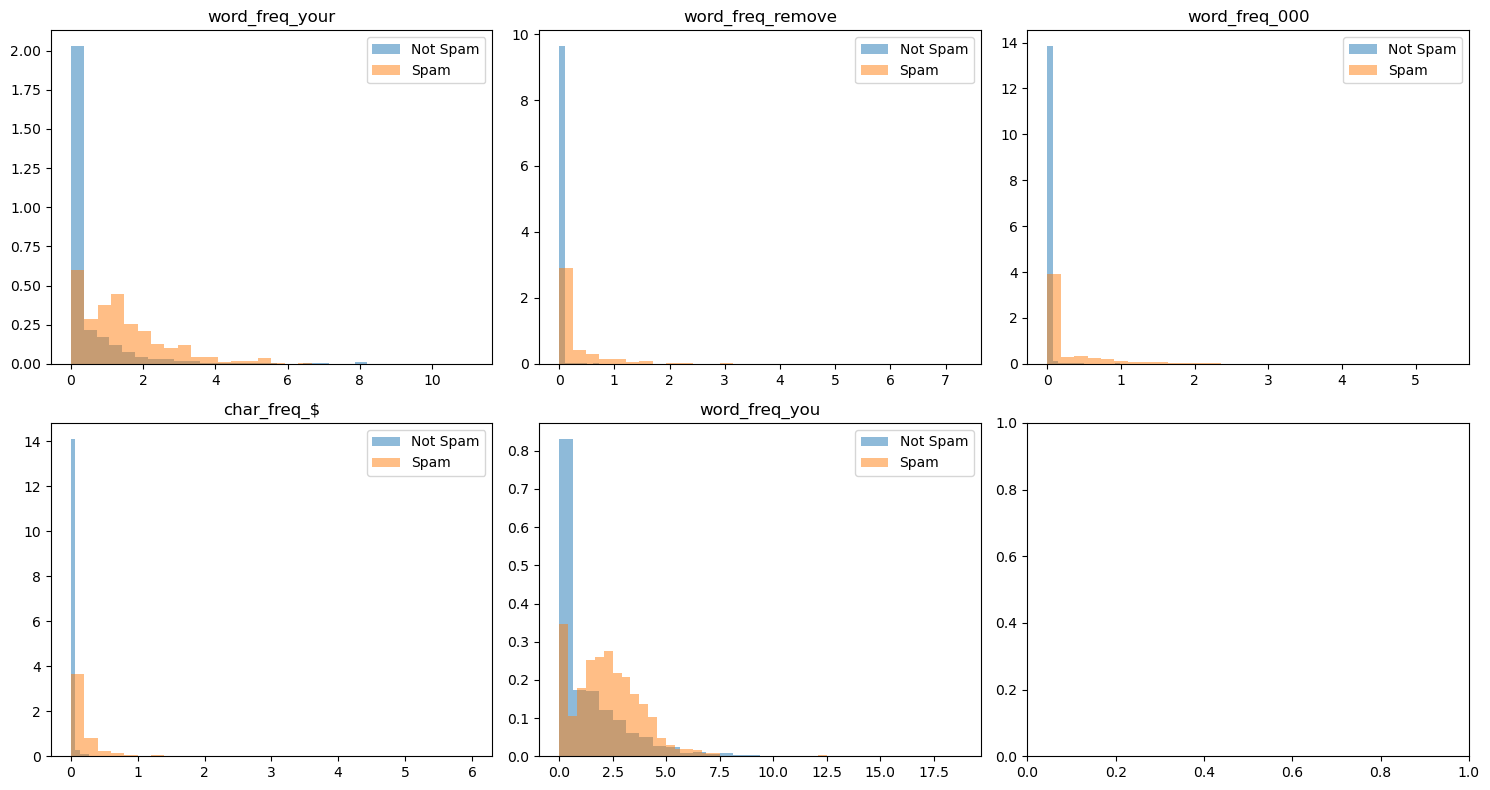

In [73]:
# TODO: Visualize distributions of top features for spam vs non-spam
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, idx in enumerate(top_5_indices[:5]):
    ax = axes[i // 3, i % 3]
    ax.hist(X[y == 0, idx], bins=30, alpha=0.5, label='Not Spam', density=True)
    ax.hist(X[y == 1, idx], bins=30, alpha=0.5, label='Spam', density=True)
    ax.set_title(f'{feature_names[idx]}')
    ax.legend()
plt.tight_layout()
plt.show()

## Summary and Discussion

### Results Table
| Metric | Value |
|--------|-------|
| Accuracy | 82.1739 |
| Precision | 72.3320 |
| Recall | 93.8462 |
| F1-Score | 81.6964 |

### Top 5 Discriminative Features
1. Feature 20 - word_freq_your
2. Feature  6 - word_freq_remove
3. Feature 22 - word_freq_000
4. Feature 52 - char_freq_$
5. Feature 18 - word_freq_you

### Discussion
*Answer these questions:*
1. Why is Naive Bayes effective for spam detection despite the independence assumption?
    - Naive Bayes is a simple algortihm that is computationally efficient. Computational efficiency is a key aspect when implementing ML methods. In our case we are scrubbing emails for spam. We need to have real time capabilities so the email is being sent to the reciepent as quick as possible. Models like SVM will not scale with the demand.

2. What are the limitations of your implementation?
    -  We are using a fixed epsilon and no tuning on paramters. There were also 140 real emails identified as spam emails. I hypothesis this is due to a limted dataset and not parameter tuning. From the top 5 discriminitive features we can see "your" and "you" play a key role. These are common words which can be throwing the model off.

3. How could you improve the classifier?
    - We could modify the features such as combining "you" and "your" into one category to see if we can reduce the weight of the feature. This way we can understand the underlying pattern and hopefully improve model score.
    - We can also tune the decision threshold to find optimal paramters.

4. What did you learn from this exercise?
    - In this exercise we built a Gaussian Naive Bayes mdoel from scratch, which helped link the theoretical side to implementation in code. The exercise also helped udnerstand the model parameters and what tuning them does. 
